# Fourier continuations of third kind

This notebook implements Fourier continuations of the third kind with iterative refinement and overcollocation to decompose a non-periodic function into plane waves. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 

In [34]:
def getFPICSUMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N), dtype=complex)
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.exp(1j * j * np.pi / theta * x[i])
    return M, x

def invertComplexM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape, dtype=complex)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T.conjugate() @ sinv @ U.T.conjugate()

Reproduce figure 8


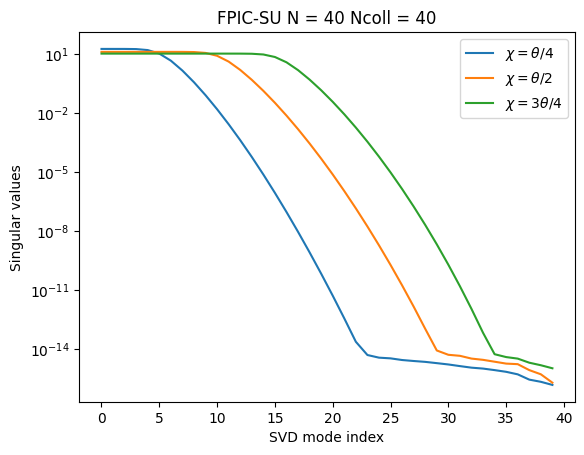

In [35]:

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index") 
plt.yscale("log") 

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for chi, label in zip(chis, labels): 
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label)
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [36]:
chi = theta/2 

M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

Compute pseudoinverse by inverting $S$ with cutoff

In [37]:


#Test implementation of invert M
A = np.random.rand(32, 32) + 1j * np.random.rand(32, 32)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertComplexM(A, 0)), 0, atol=1e-13)


Finally compute the periodic extension of an arbitrary complex function ($f(x) = e^x + i e^x $ in this example)

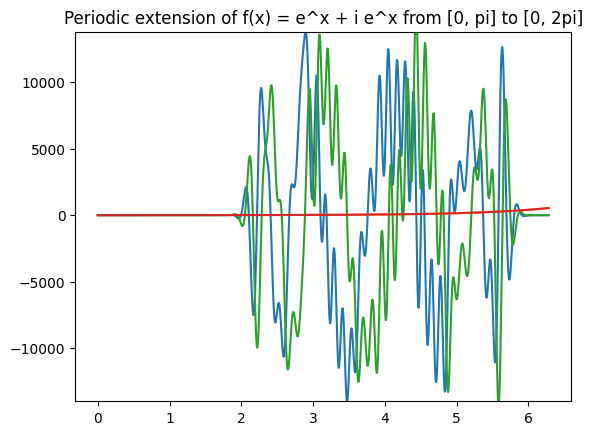

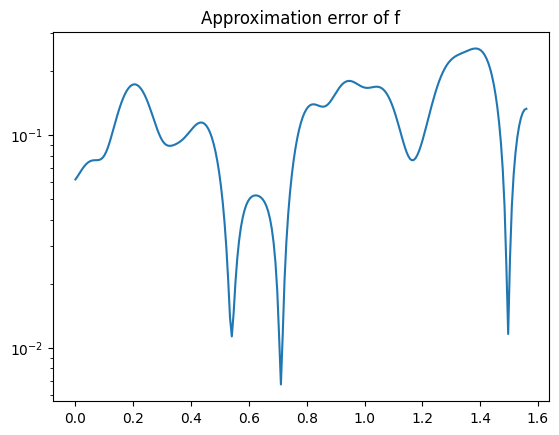

In [38]:
N     = 64
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape, dtype=complex) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.exp(1j * np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

Improve this result by using iterative refinement

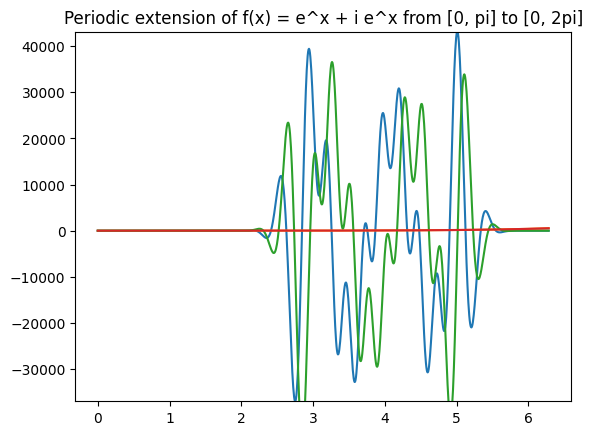

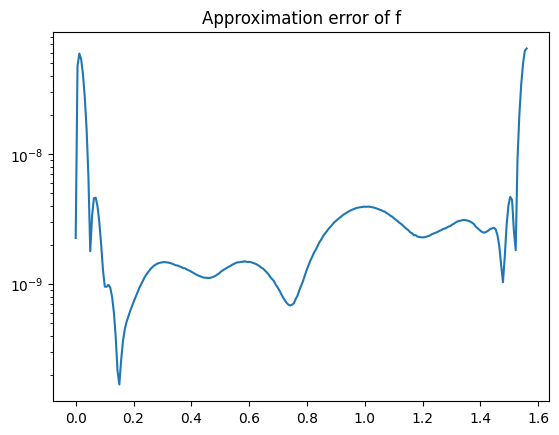

In [40]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 10, maxiter = 3)

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

## Can we get superior performance by splitting everything into symmetric and antisymmetric parts and doing 4 real SVDs?

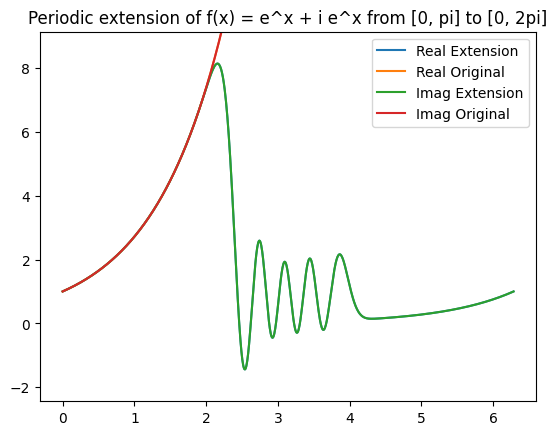

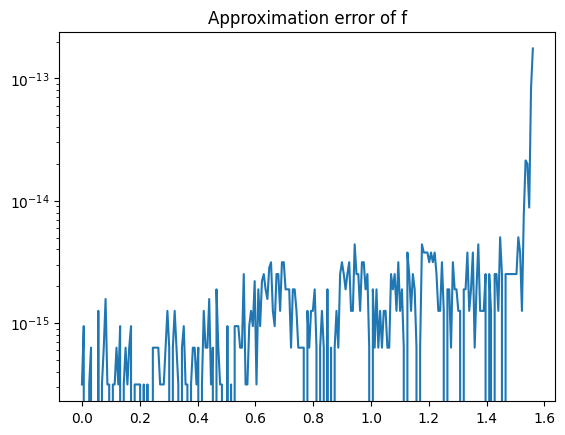

In [51]:
def getFPICSUEvenMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

def getFPICSUOddMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.sin(j * np.pi / theta * x[i])
    return M, x

def invertRealM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T


def reconstructOdd(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.sin(np.pi / theta * j * x)
    return rec

def reconstructEven(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

N     = 32
Ncoll = N * 2
theta = np.pi
chi   = theta/2 
Meven, x  = getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
Modd,  x  = getFPICSUOddMatrix (N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

Meveninv  = invertRealM(Meven, 1e-14)
Moddinv   = invertRealM(Modd,  1e-14)

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)

f      = func(x)
feven  = (func(x) + func(-x)).real/2
fodd   = (func(x) - func(-x)).real/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 10)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 10)
freal  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
feven  = (func(x) + func(-x)).imag/2
fodd   = (func(x) - func(-x)).imag/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 10)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 10)
fimag  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
frec   = freal + 1j * fimag

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

## The all-in-one solution

In [ ]:
class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.M, self.x = self.getFPICSUMatrix(N, Ncoll, theta, chi)
        self.Minv      = self.invertM(self.M, cutoff)


    def getFPICSUMatrix(self, N, Ncoll, theta, chi): 
        x = np.zeros(Ncoll)
        M = np.zeros((Ncoll, N), dtype=complex)
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                x[i]    = i * chi / (Ncoll - 1) 
                M[i, j] = np.exp(1j * j * np.pi / theta * x[i])
        return M, x

    def invertM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape, dtype=complex)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T.conjugate() @ sinv @ U.T.conjugate()